# Chapter 5 Classification
### Imported libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score

### The Naive Solution

In [2]:
loan_data = pd.read_csv('loan_data.csv')

In [3]:
predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model.fit(X, y)

MultinomialNB(alpha=0.01)

In [4]:
new_loan = X.loc[146:146, :]

In [5]:
print('predicted class: ', naive_model.predict(new_loan)[0])

probabilites = pd.DataFrame(naive_model.predict_proba(new_loan),
                            columns=naive_model.classes_)
print('predicted probabilites')
print(probabilites)

predicted class:  default
predicted probabilites
    default  paid off
0  0.653696  0.346304


### Fisher's Linear Discriminant

In [6]:
loan3000 = pd.read_csv('loan3000.csv')

In [7]:
loan3000.outcome = loan3000.outcome.astype('category')

In [8]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
pd.DataFrame(loan_lda.scalings_, index=X.columns)

,0
borrower_score,7.175839
payment_inc_ratio,-0.099676


In [9]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)
pred.head()

,default,paid off
0,0.553544,0.446456
1,0.558953,0.441047
2,0.272696,0.727304
3,0.506254,0.493746
4,0.609952,0.390048


In [10]:
#Use scalings and center of means to determine decision boundary
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

#payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio,default
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135,0.553544
1,16982,default,credit_card,15.49,0.40,5.43165,0.558953
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003,0.272696
3,34580,paid off,major_purchase,21.11,0.40,2.33482,0.506254
4,14424,default,debt_consolidation,16.46,0.45,12.10320,0.609952


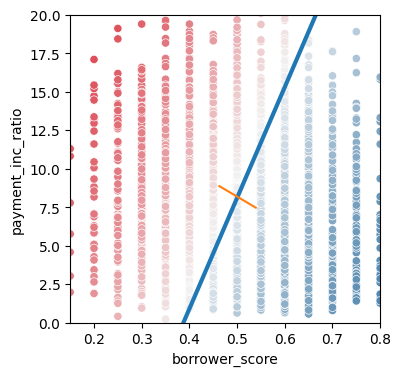

In [11]:
fig, ax = plt.subplots(figsize=(4,4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df,
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)
ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

### Logistic Regression and the GLM

In [12]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', drop_first=True)
y = loan_data[outcome]

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X,y)

LogisticRegression(C=1e+42, solver='liblinear')

### Predicted Values from Logistic Regression

In [13]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=logit_reg.classes_)
pred.describe()

,default,paid off
count,45342.000000,45342.000000
mean,-0.757872,-0.760434
std,0.378093,0.390456
min,-2.769376,-3.538593
25%,-0.985739,-0.977207
50%,-0.697406,-0.688907
75%,-0.472183,-0.467069
max,-0.029485,-0.064753


In [14]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=logit_reg.classes_)
pred.describe()

,default,paid off
count,45342.000000,45342.000000
mean,0.500000,0.500000
std,0.167354,0.167354
min,0.062701,0.029054
25%,0.373163,0.376361
50%,0.497875,0.502125
75%,0.623639,0.626837
max,0.970946,0.937299


### Assessing the Model

In [15]:
y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Sat, 10 Jun 2023   Deviance:                       57515.
Time:                        11:21:33   Pearson chi2:                 4.54e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1112
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0.002     32.058      0.000       0.075       0.085
borrower_score        -4.6126      0.084    -55.203      0.000      -4.776      -4.449
debt_consolidation     0.2494      0.028      9.030      0.000       0.195       0.303
home_improvement       0.4077      0.047      8.747      0.000       0.316       0.499
major_purchase         0.2296      0.054      4.277      0.000       0.124       0.335
medical                0.5105      0.087      5.882      0.000       0.340       0.681
other                  0.6207      0.039     15.738      0.000       0.543       0.698
small_business         1.2153      0.063     19.192      0.000       1.091       1.339
OWN                    0.0483      0.038      1.271      0.204      -0.026       0.123
RENT                   0.1573      0.021      7.420      0.000       0.116       0.199
 > 1 Year             -0.3567      0.053     -6.779      0.000      -0.460      -0.254
const                  1.6381      0.074     22.224      0.000       1.494       1.783
======================================================================================
"""

In [16]:
formula = ('outcome ~ bs(payment_inc_ratio, df=4) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=4)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()

### Confusion Matrix

In [17]:
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y
conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)],
                        [np.sum(false_pos), np.sum(true_neg)]],
                        index = ['Y = default', 'Y = paid off'],
                        columns=['Yhat = dafault', 'Yhat = paid off'])
conf_mat

,Yhat = dafault,Yhat = paid off
Y = default,14337,8334
Y = paid off,8149,14522


### Precision, Recall, and Specificity

In [18]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precision', conf_mat[0,0] / sum(conf_mat[:, 0]))
print('Recall', conf_mat[0,0] / sum(conf_mat[0, :]))
print('Specificity', conf_mat[1, 1] / sum(conf_mat[1, :]))

precision_recall_fscore_support(y, logit_reg.predict(X),
                                labels=['default', 'paid off'])

Precision 0.6375967268522637
Recall 0.6323938070662961
Specificity 0.640554011733051


(array([0.63759673, 0.63536927]),
 array([0.63239381, 0.64055401]),
 array([0.63498461, 0.63795111]),
 array([22671, 22671], dtype=int64))

### ROC Curve

Text(0, 0.5, 'recall')

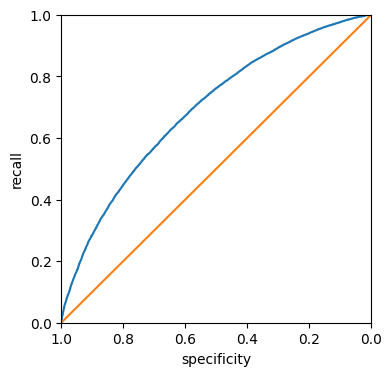

In [19]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0],
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4,4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')

### AUC

In [20]:
print(np.sum(roc_df.recall[:-1]*np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y],
                    logit_reg.predict_proba(X)[:, 0]))

0.6917107174637571
0.691710795288669


### Undersampling

In [21]:
full_train_set = pd.read_csv('full_train_set.csv')
full_train_set.shape

(119987, 19)

In [22]:
print('percentage of loans in default: ',
      100 * np.mean(full_train_set.outcome == 'default'))

percentage of loans in default:  18.894546909248504


In [23]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_',
              'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='',
                   drop_first=True)
y = full_train_set[outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y)
print('percentage of loans predicted to default: ',
      100*np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to default:  1.0134431230049923


### Oversampling and Up/Down Weighting

In [24]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
wt = [default_wt if outcome == 'default' else 1
      for outcome in full_train_set.outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y, sample_weight=wt)
print('percentage of loans predicted to default (weighting): ',
      100*np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to default (weighting):  61.52833223599223
